In [ ]:
pip install scikit-surprise

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [14]:
df_final = pd.read_csv("../data/goodbooks-10k/final_svd_dataset.csv")

In [ ]:
df_final.groupby('decade')['book_id'].count(),uniqeu


decade
1920               77298
1930              121695
1940              133772
1950              254674
1960              249719
1970              244194
1980              443368
1990              847948
2000             1808808
2010             1268418
Ancient Books     520643
Name: book_id, dtype: int64

In [23]:
df_final.groupby('decade')['book_id'].nunique()

decade
1920               89
1930              121
1940              155
1950              210
1960              272
1970              400
1980              704
1990             1360
2000             3121
2010             3067
Ancient Books     480
Name: book_id, dtype: int64

In [ ]:
df_final['rating'].describe()

count    5.970537e+06
mean     3.919667e+00
std      9.910473e-01
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [72]:
df_final.columns

Index(['user_id', 'book_id', 'rating', 'decade'], dtype='object')

In [24]:
df_final

,user_id,book_id,rating,decade
0,1,258,5,2000
1,2,4081,4,2000
2,2,260,5,1930
3,2,9296,5,1970
4,2,2318,3,1990
...,...,...,...,...
5970532,49925,510,5,1990
5970533,49925,528,4,1990
5970534,49925,722,4,1990
5970535,49925,949,5,1990


In [ ]:
import pandas as pd
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
import csv
import os

# ---------------------
# Load dataset
# ---------------------
df_final = pd.read_csv("df_original.csv")  # Ensure the file is in the same directory

# Optional: Convert user_id and book_id to strings (Surprise handles strings better)
df_final['user_id'] = df_final['user_id'].astype(str)
df_final['book_id'] = df_final['book_id'].astype(str)

# ---------------------
# Prepare Surprise Dataset
# ---------------------
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_final[['user_id', 'book_id', 'rating']], reader)

# Split into train and test sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# ---------------------
# Train SVD model
# ---------------------
svd = SVD(n_factors=100, random_state=42)
svd.fit(trainset)

# ---------------------
# Evaluate RMSE
# ---------------------
predictions = svd.test(testset)
rmse = accuracy.rmse(predictions)
# ---------------------
# Generate Top-25 Recommendations per User
# ---------------------
all_user_ids = df_final['user_id'].unique()
all_book_ids = df_final['book_id'].unique()

user_recommendations = {}

print("Generating recommendations...")
for i, user_id in enumerate(all_user_ids):
    rated_books = df_final[df_final['user_id'] == user_id]['book_id'].tolist()
    unseen_books = [book for book in all_book_ids if book not in rated_books]
    
    preds = [(book, svd.predict(user_id, book).est) for book in unseen_books]
    top_preds = sorted(preds, key=lambda x: x[1], reverse=True)[:25]
    
    user_recommendations[user_id] = [book for book, _ in top_preds]
    
    if i % 500 == 0:
        print(f"Processed {i}/{len(all_user_ids)} users")

# ---------------------
# Save Recommendations to CSV
# ---------------------
with open('user_recommendations.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['user_id', 'recommended_books'])
    for user_id, books in user_recommendations.items():
        writer.writerow([user_id, ','.join(map(str, books))])

# ---------------------
# Save RMSE to a text file
# ---------------------
with open('svd_rmse.txt', 'w') as f:
    f.write(f"RMSE: {rmse:.4f}\n")

# ---------------------
# Optional: Load and display a preview
# ---------------------
df_recommendations = pd.read_csv('user_recommendations.csv')
print("\nSample recommendations:")
print(df_recommendations.head())


KeyboardInterrupt: 

In [ ]:
import os
import pandas as pd
from transformers import pipeline
from tqdm import tqdm
from collections import Counter

# === Load dataset ===
data_path = '../data/goodbooks-10k'
books = pd.read_csv(os.path.join(data_path, 'books.csv'))
df_books = books[['book_id', 'original_title', 'authors']].dropna(subset=['original_title']).reset_index(drop=True)

# === Take 10% of data ===
num_books_10_percent = int(len(df_books) * 0.10)
df_books_sample = df_books.iloc[:num_books_10_percent].reset_index(drop=True)

GENRE_LIST = [
    "Fantasy", "Science Fiction", "Romance", "Mystery", "Thriller",
    "Historical", "Adult", "Horror", "Children's",
    "Adventure", "Classics", "Nonfiction", "Drama"
]

# === Initialize zero-shot classification pipeline ===
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

genres_predicted = []

BATCH_SIZE = 100
for start in tqdm(range(0, len(df_books_sample), BATCH_SIZE), desc="Processing batches"):
    end = min(start + BATCH_SIZE, len(df_books_sample))
    batch_df = df_books_sample.iloc[start:end]
    titles = [f"{title} by {author}" for title, author in zip(batch_df['original_title'], batch_df['authors'])]
    results = classifier(titles, GENRE_LIST, multi_label=True)
    for result, title in zip(results, titles):
        top2 = sorted(zip(result['labels'], result['scores']), key=lambda x: -x[1])[:2]
        top2_genres = f"{top2[0][0]}, {top2[1][0]}"
        genres_predicted.append(top2_genres)
        print(f"{title} → {top2_genres}")

# Add predictions to dataframe
df_books_sample['genres'] = genres_predicted

# Count genre occurrences in top-2 predictions
genre_counter = Counter()
for entry in genres_predicted:
    for genre in entry.split(', '):
        genre_counter[genre] += 1

# Print counts per genre
print("\n✅ Genre prediction counts in 10% sample:")
for genre, count in genre_counter.most_common():
    print(f"{genre}: {count}")

# Save predictions
df_books_sample.to_csv("/home/moshtasa/Research/phd-svd-recsys/SVD/Book/data/LLM/10%k_zeroshot_10percent.csv", index=False)

print("\n✅ 10% of books processed and saved to 10k_zeroshot_10percent.csv!")



📚 Number of unique books processed:
Zero-shot dataset: 8600 unique books
FLAN-T5 dataset:   9415 unique books

📊 Genre counts (Zero-shot vs FLAN-T5):

Adult           | Zero-shot:  3719 | FLAN-T5:   839
Adventure       | Zero-shot:   357 | FLAN-T5:   316
Children's      | Zero-shot:   622 | FLAN-T5:  1159
Classics        | Zero-shot:   713 | FLAN-T5:   188
Drama           | Zero-shot:  1367 | FLAN-T5:  1284
Fantasy         | Zero-shot:   702 | FLAN-T5:  1794
Historical      | Zero-shot:  1548 | FLAN-T5:   957
Horror          | Zero-shot:  1150 | FLAN-T5:    48
Mystery         | Zero-shot:   355 | FLAN-T5:  1847
Nonfiction      | Zero-shot:  3663 | FLAN-T5:  1988
Romance         | Zero-shot:   642 | FLAN-T5:  2028
Science Fiction | Zero-shot:  1976 | FLAN-T5:  1023
Thriller        | Zero-shot:   386 | FLAN-T5:  5359


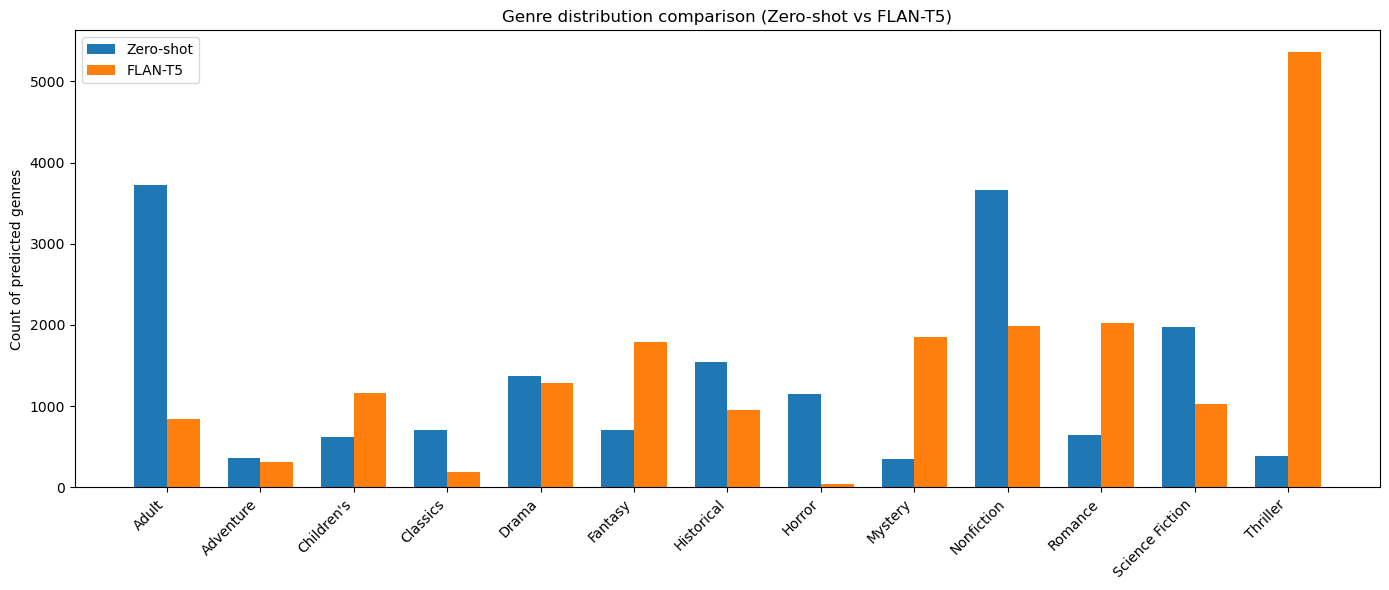

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# === File paths ===
file_zeroshot = "/home/moshtasa/Research/phd-svd-recsys/SVD/Book/data/LLM/10k_zeroshot.csv"
file_flan = "/home/moshtasa/Research/phd-svd-recsys/SVD/Book/data/LLM/10k_flan_t5.csv"

# === Read both datasets ===
df_zeroshot = pd.read_csv(file_zeroshot)
df_flan = pd.read_csv(file_flan)

# === Count number of unique books in each dataset ===
num_uniq_zeroshot = df_zeroshot['book_id'].nunique()
num_uniq_flan = df_flan['book_id'].nunique()

print(f"\n📚 Number of unique books processed:")
print(f"Zero-shot dataset: {num_uniq_zeroshot} unique books")
print(f"FLAN-T5 dataset:   {num_uniq_flan} unique books")

# === Function to count genres in a dataframe ===
def count_genres(df):
    genre_counter = Counter()
    for entry in df['genres'].dropna():
        for genre in entry.split(', '):
            genre_counter[genre] += 1
    return genre_counter

counts_zeroshot = count_genres(df_zeroshot)
counts_flan = count_genres(df_flan)

# === Sort genres for consistent plotting ===
all_genres = sorted(set(counts_zeroshot.keys()).union(counts_flan.keys()))

zeroshot_values = [counts_zeroshot.get(g, 0) for g in all_genres]
flan_values = [counts_flan.get(g, 0) for g in all_genres]

# === Print the numbers for each genre ===
print("\n📊 Genre counts (Zero-shot vs FLAN-T5):\n")
for genre, z_count, f_count in zip(all_genres, zeroshot_values, flan_values):
    print(f"{genre:15s} | Zero-shot: {z_count:5d} | FLAN-T5: {f_count:5d}")

# === Create side-by-side bar plot ===
x = range(len(all_genres))
width = 0.35

plt.figure(figsize=(14, 6))
plt.bar(x, zeroshot_values, width=width, label="Zero-shot", align='center')
plt.bar([i + width for i in x], flan_values, width=width, label="FLAN-T5", align='center')

plt.xticks([i + width/2 for i in x], all_genres, rotation=45, ha='right')
plt.ylabel("Count of predicted genres")
plt.title("Genre distribution comparison (Zero-shot vs FLAN-T5)")
plt.legend()
plt.tight_layout()
plt.show()



📚 Number of books processed:
Zero-shot dataset (10% sample): 941 books
FLAN-T5 dataset (full):         9415 books

📊 Estimated genre counts (Zero-shot ×10) vs FLAN-T5:

Adult           | Zero-shot (×10):  3990 | FLAN-T5:   839
Adventure       | Zero-shot (×10):   390 | FLAN-T5:   316
Children's      | Zero-shot (×10):   650 | FLAN-T5:  1159
Classics        | Zero-shot (×10):  1510 | FLAN-T5:   188
Drama           | Zero-shot (×10):  1710 | FLAN-T5:  1284
Fantasy         | Zero-shot (×10):  1040 | FLAN-T5:  1794
Historical      | Zero-shot (×10):  1310 | FLAN-T5:   957
Horror          | Zero-shot (×10):  1380 | FLAN-T5:    48
Mystery         | Zero-shot (×10):   350 | FLAN-T5:  1847
Nonfiction      | Zero-shot (×10):  3070 | FLAN-T5:  1988
Romance         | Zero-shot (×10):   880 | FLAN-T5:  2028
Science Fiction | Zero-shot (×10):  1940 | FLAN-T5:  1023
Thriller        | Zero-shot (×10):   600 | FLAN-T5:  5359


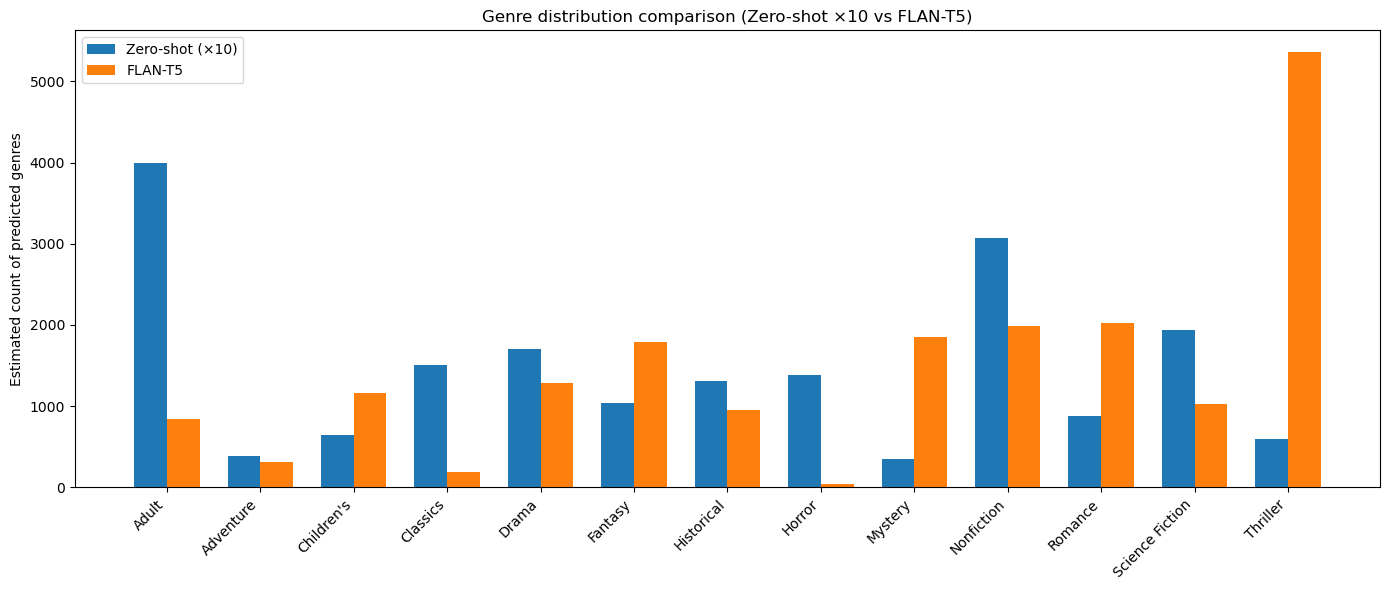

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# === File paths ===
file_zeroshot = "/home/moshtasa/Research/phd-svd-recsys/SVD/Book/data/LLM/10%k_zeroshot_10percent.csv"
file_flan = "/home/moshtasa/Research/phd-svd-recsys/SVD/Book/data/LLM/10k_flan_t5.csv"

# === Read both datasets ===
df_zeroshot = pd.read_csv(file_zeroshot)
df_flan = pd.read_csv(file_flan)

# === Count number of books ===
num_books_zeroshot = len(df_zeroshot)
num_books_flan = len(df_flan)

print(f"\n📚 Number of books processed:")
print(f"Zero-shot dataset (10% sample): {num_books_zeroshot} books")
print(f"FLAN-T5 dataset (full):         {num_books_flan} books")

# === Function to count genres in a dataframe ===
def count_genres(df):
    genre_counter = Counter()
    for entry in df['genres'].dropna():
        for genre in entry.split(', '):
            genre_counter[genre] += 1
    return genre_counter

counts_zeroshot = count_genres(df_zeroshot)
counts_flan = count_genres(df_flan)

# === Multiply zero-shot counts by 10 to approximate full dataset ===
counts_zeroshot_scaled = {genre: count * 10 for genre, count in counts_zeroshot.items()}

# === Sort genres for consistent plotting ===
all_genres = sorted(set(counts_zeroshot_scaled.keys()).union(counts_flan.keys()))

zeroshot_values = [counts_zeroshot_scaled.get(g, 0) for g in all_genres]
flan_values = [counts_flan.get(g, 0) for g in all_genres]

# === Print the values for each genre ===
print("\n📊 Estimated genre counts (Zero-shot ×10) vs FLAN-T5:\n")
for genre, z_val, f_val in zip(all_genres, zeroshot_values, flan_values):
    print(f"{genre:15s} | Zero-shot (×10): {z_val:5d} | FLAN-T5: {f_val:5d}")

# === Create side-by-side bar plot ===
x = range(len(all_genres))
width = 0.35

plt.figure(figsize=(14, 6))
plt.bar(x, zeroshot_values, width=width, label="Zero-shot (×10)", align='center')
plt.bar([i + width for i in x], flan_values, width=width, label="FLAN-T5", align='center')

plt.xticks([i + width/2 for i in x], all_genres, rotation=45, ha='right')
plt.ylabel("Estimated count of predicted genres")
plt.title("Genre distribution comparison (Zero-shot ×10 vs FLAN-T5)")
plt.legend()
plt.tight_layout()
plt.show()


In [25]:
import os
import pandas as pd

# === Load dataset ===

books = pd.read_csv("/home/moshtasa/Research/phd-svd-recsys/SVD/Book/data/LLM/10k_flan_t5.csv")
df_books = books[['book_id', 'original_title', 'authors']].dropna(subset=['original_title']).reset_index(drop=True)

# === Count unique book IDs ===
num_unique_book_ids = df_books['book_id'].nunique()
print(f"✅ Number of unique book IDs: {num_unique_book_ids}")


✅ Number of unique book IDs: 9415


In [11]:
import os
import pandas as pd

# === Load dataset ===
data_path = '../data/goodbooks-10k'
books = pd.read_csv(os.path.join(data_path, 'books.csv'))
df_books = books[['book_id', 'original_title', 'authors']].dropna(subset=['original_title']).reset_index(drop=True)

# === Count total number of books ===
num_books_total = len(df_books)
print(f"✅ Total number of books in dataset: {num_books_total}")


✅ Total number of books in dataset: 9415


In [12]:
# Define your local data path
data_path = '../data/goodbooks-10k'  # adjust path if needed

# Load all available CSV files
books = pd.read_csv(os.path.join(data_path, 'books.csv'))
ratings = pd.read_csv(os.path.join(data_path, 'ratings.csv'))
to_read = pd.read_csv(os.path.join(data_path, 'to_read.csv'))
book_tags = pd.read_csv(os.path.join(data_path, 'book_tags.csv'))
tags = pd.read_csv(os.path.join(data_path, 'tags.csv'))

# Quick verification:
print(f"books.csv shape: {books.shape}")
print(f"ratings.csv shape: {ratings.shape}")
print(f"to_read.csv shape: {to_read.shape}")
print(f"book_tags.csv shape: {book_tags.shape}")
print(f"tags.csv shape: {tags.shape}")

# Preview few rows from each file:
print("\nBooks sample:")
print(books.head())

print("\nRatings sample:")
print(ratings.head())

print("\nTo-Read sample:")
print(to_read.head())

print("\nBook Tags sample:")
print(book_tags.head())

print("\nTags sample:")
print(tags.head())


books.csv shape: (10000, 23)
ratings.csv shape: (5976479, 3)
to_read.csv shape: (912705, 2)
book_tags.csv shape: (999912, 3)
tags.csv shape: (34252, 2)

Books sample:
   book_id  goodreads_book_id  best_book_id  work_id  books_count       isbn  \
0        1            2767052       2767052  2792775          272  439023483   
1        2                  3             3  4640799          491  439554934   
2        3              41865         41865  3212258          226  316015849   
3        4               2657          2657  3275794          487   61120081   
4        5               4671          4671   245494         1356  743273567   

         isbn13                      authors  original_publication_year  \
0  9.780439e+12              Suzanne Collins                     2008.0   
1  9.780440e+12  J.K. Rowling, Mary GrandPré                     1997.0   
2  9.780316e+12              Stephenie Meyer                     2005.0   
3  9.780061e+12                   Harper Lee        